# Exploratory Data Analysis (EDA) and Cleaning | S&P 1500 Companies
---

## Import libraries and modules

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Pivoted Data

- Load `pivot_sp500.csv` and `pivot_sp1000.csv` from `data` folder into a pandas DataFrame
- Check data types for each columns

In [2]:
edgar_sp500 = pd.read_csv('../data/pivot_sp500.csv', low_memory=False)
edgar_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065 entries, 0 to 3064
Columns: 47929 entries, A A G Mandatorily Convertible Preferred Stock to year
dtypes: float64(38240), int64(1), object(9688)
memory usage: 1.1+ GB


In [3]:
edgar_sp1000 = pd.read_csv('../data/pivot_sp1000.csv', low_memory=False)
edgar_sp1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4918 entries, 0 to 4917
Columns: 60002 entries, A A C Note Securedby R M B S Securities Value Not Less Than to year
dtypes: float64(49206), int64(1), object(10795)
memory usage: 2.2+ GB


---

## Concatenate `edgar_sp500` and `edgar_sp1000`

In [4]:
df = pd.concat((edgar_sp500, edgar_sp1000)).reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7983 entries, 0 to 7982
Columns: 98308 entries, A A G Mandatorily Convertible Preferred Stock to Zero Point Five Percent Decrease In Expected Long Term Rate Of Return On Plan Assets Estimated Effect On Pension Expense
dtypes: float64(79662), int64(1), object(18645)
memory usage: 5.8+ GB


---

In [6]:
df = df[df.isnull().sum().sort_values()[:50].index]

In [7]:
float_fs = [f for f in df.columns if df[f].dtypes != 'O']

In [8]:
df[float_fs] = df[float_fs].fillna(0).astype(float)
df['Document Period End Date'] = pd.to_datetime(df['Document Period End Date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7983 entries, 0 to 7982
Data columns (total 50 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   security                                                                          7983 non-null   object        
 1   year                                                                              7983 non-null   float64       
 2   Cash And Cash Equivalents At Carrying Value                                       7983 non-null   float64       
 3   Income Tax Expense Benefit                                                        7983 non-null   float64       
 4   Stockholders Equity                                                               7983 non-null   float64       
 5   Weighted Average Number Of Diluted Shares Outstanding         

---

In [10]:
df.isnull().sum(1).value_counts()

0     4933
10    3045
9        3
2        1
8        1
dtype: int64

In [11]:
df = df[df.isnull().sum(1) == 0]

---

## Plotting And Interpreting Data

### Distribution Boxplot Of Values By Features

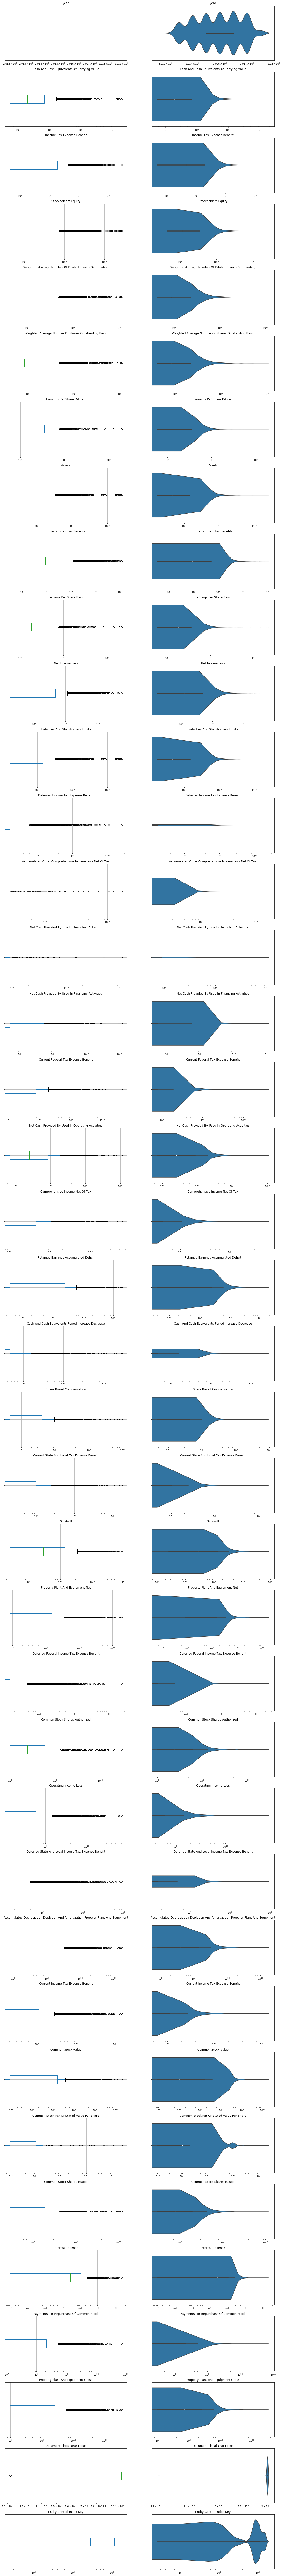

In [12]:
nrows = len(float_fs)
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20, 5 * nrows))
for n, f in enumerate(float_fs):
    df.boxplot(column=f, ax=ax[n, 0], vert=False)
    ax[n, 0].set_title(f)
    ax[n, 0].set_yticklabels([])
    ax[n, 0].set_xscale('log')
    
    sns.violinplot(x=f, data=df, ax=ax[n, 1])
    ax[n, 1].set_title(f)
    ax[n, 1].set_xlabel('')
    ax[n, 1].set_xscale('log')    

In [13]:
df.loc[df['Document Fiscal Year Focus'] < 1300, ['year', 'Document Period End Date', 'Document Fiscal Year Focus']]

,year,Document Period End Date,Document Fiscal Year Focus
1522,2015.0,2015-12-31,1215.0
1523,2016.0,2016-12-31,1216.0
1524,2017.0,2017-12-31,1217.0
1525,2018.0,2018-12-31,1218.0


There's an obvious error in `Document Fiscal Year Focus` as majority of the data lies within the 2010s. Since the correct value is the same as `year` and `Document Period End Date`, to drop this feature.

In [14]:
df.drop(
    columns=['Document Fiscal Year Focus', 'Entity Central Index Key'],
    inplace=True
)

---

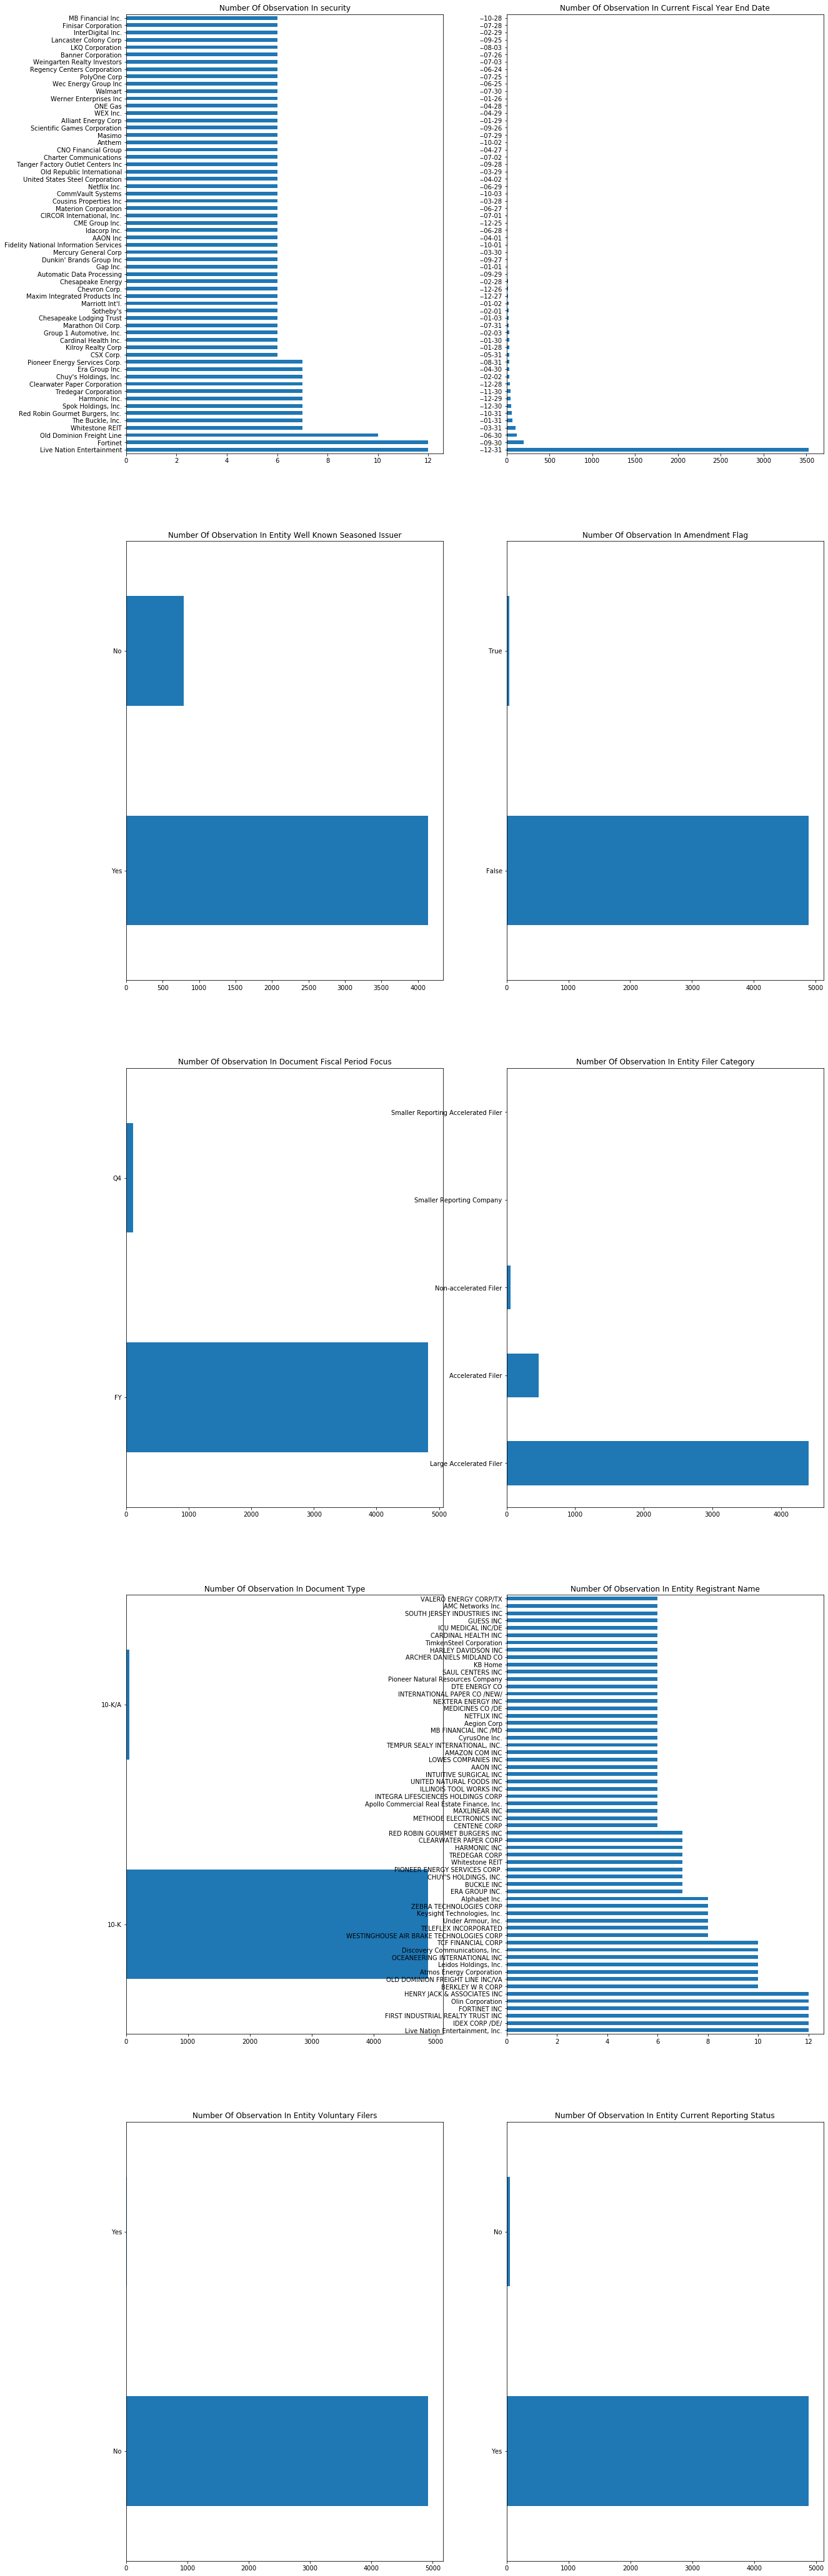

In [15]:
str_fs = [f for f in df.columns if df[f].dtypes == 'O']
ncols = 2
nrows = len(str_fs) // ncols
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15 * nrows))
ax = ax.ravel()
for n, f in enumerate(str_fs):
    df[f].value_counts().iloc[:60].plot.barh(
        title='Number Of Observation In {}'.format(f),
        ax=ax[n]
    );

In [16]:
df.drop(
    columns=['Current Fiscal Year End Date', 'Entity Registrant Name'],
    inplace=True
)

---

### Generate a line plot for `Document Period End Date` with time on the $x$-axis.

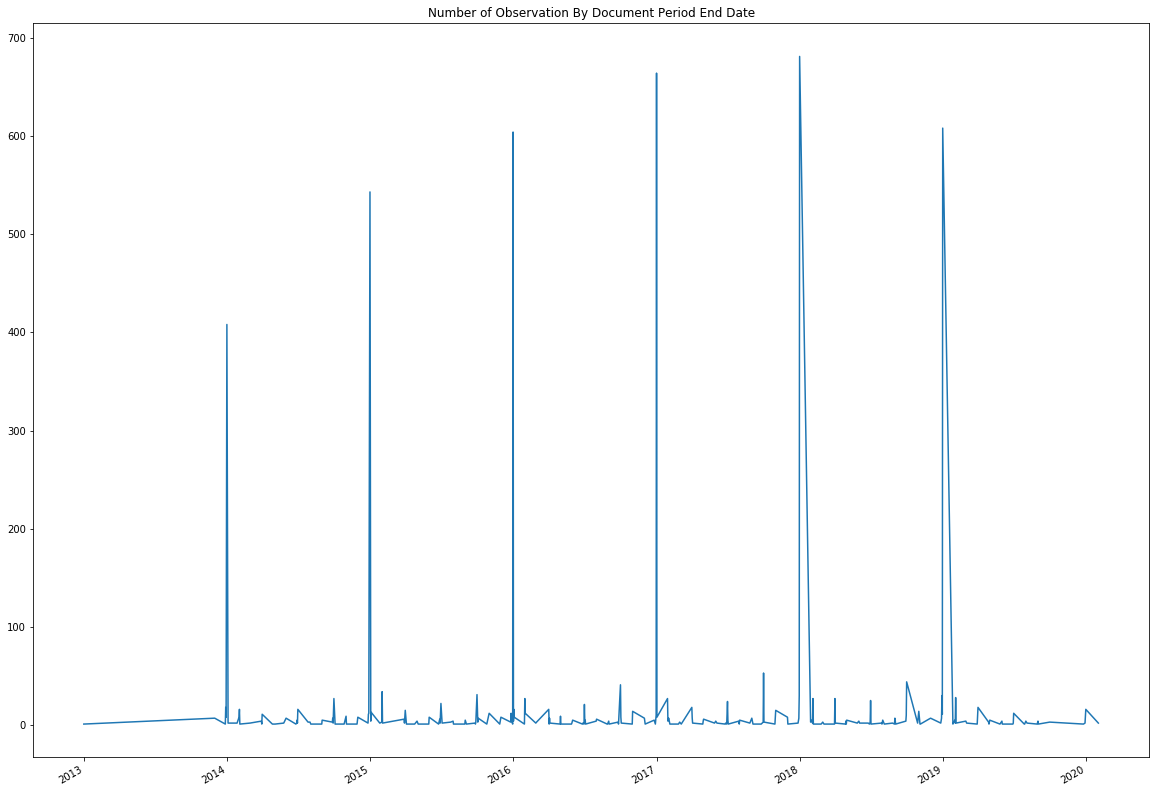

In [17]:
df['Document Period End Date'].value_counts().plot(
    figsize=(20, 15), 
    title='Number of Observation By Document Period End Date'
);

- There are clearly spikes at the end of every years. This is likely due to most companies having fiscal year end dates on 31 December. 

---

### Visualize Correlation Using A Heat Map

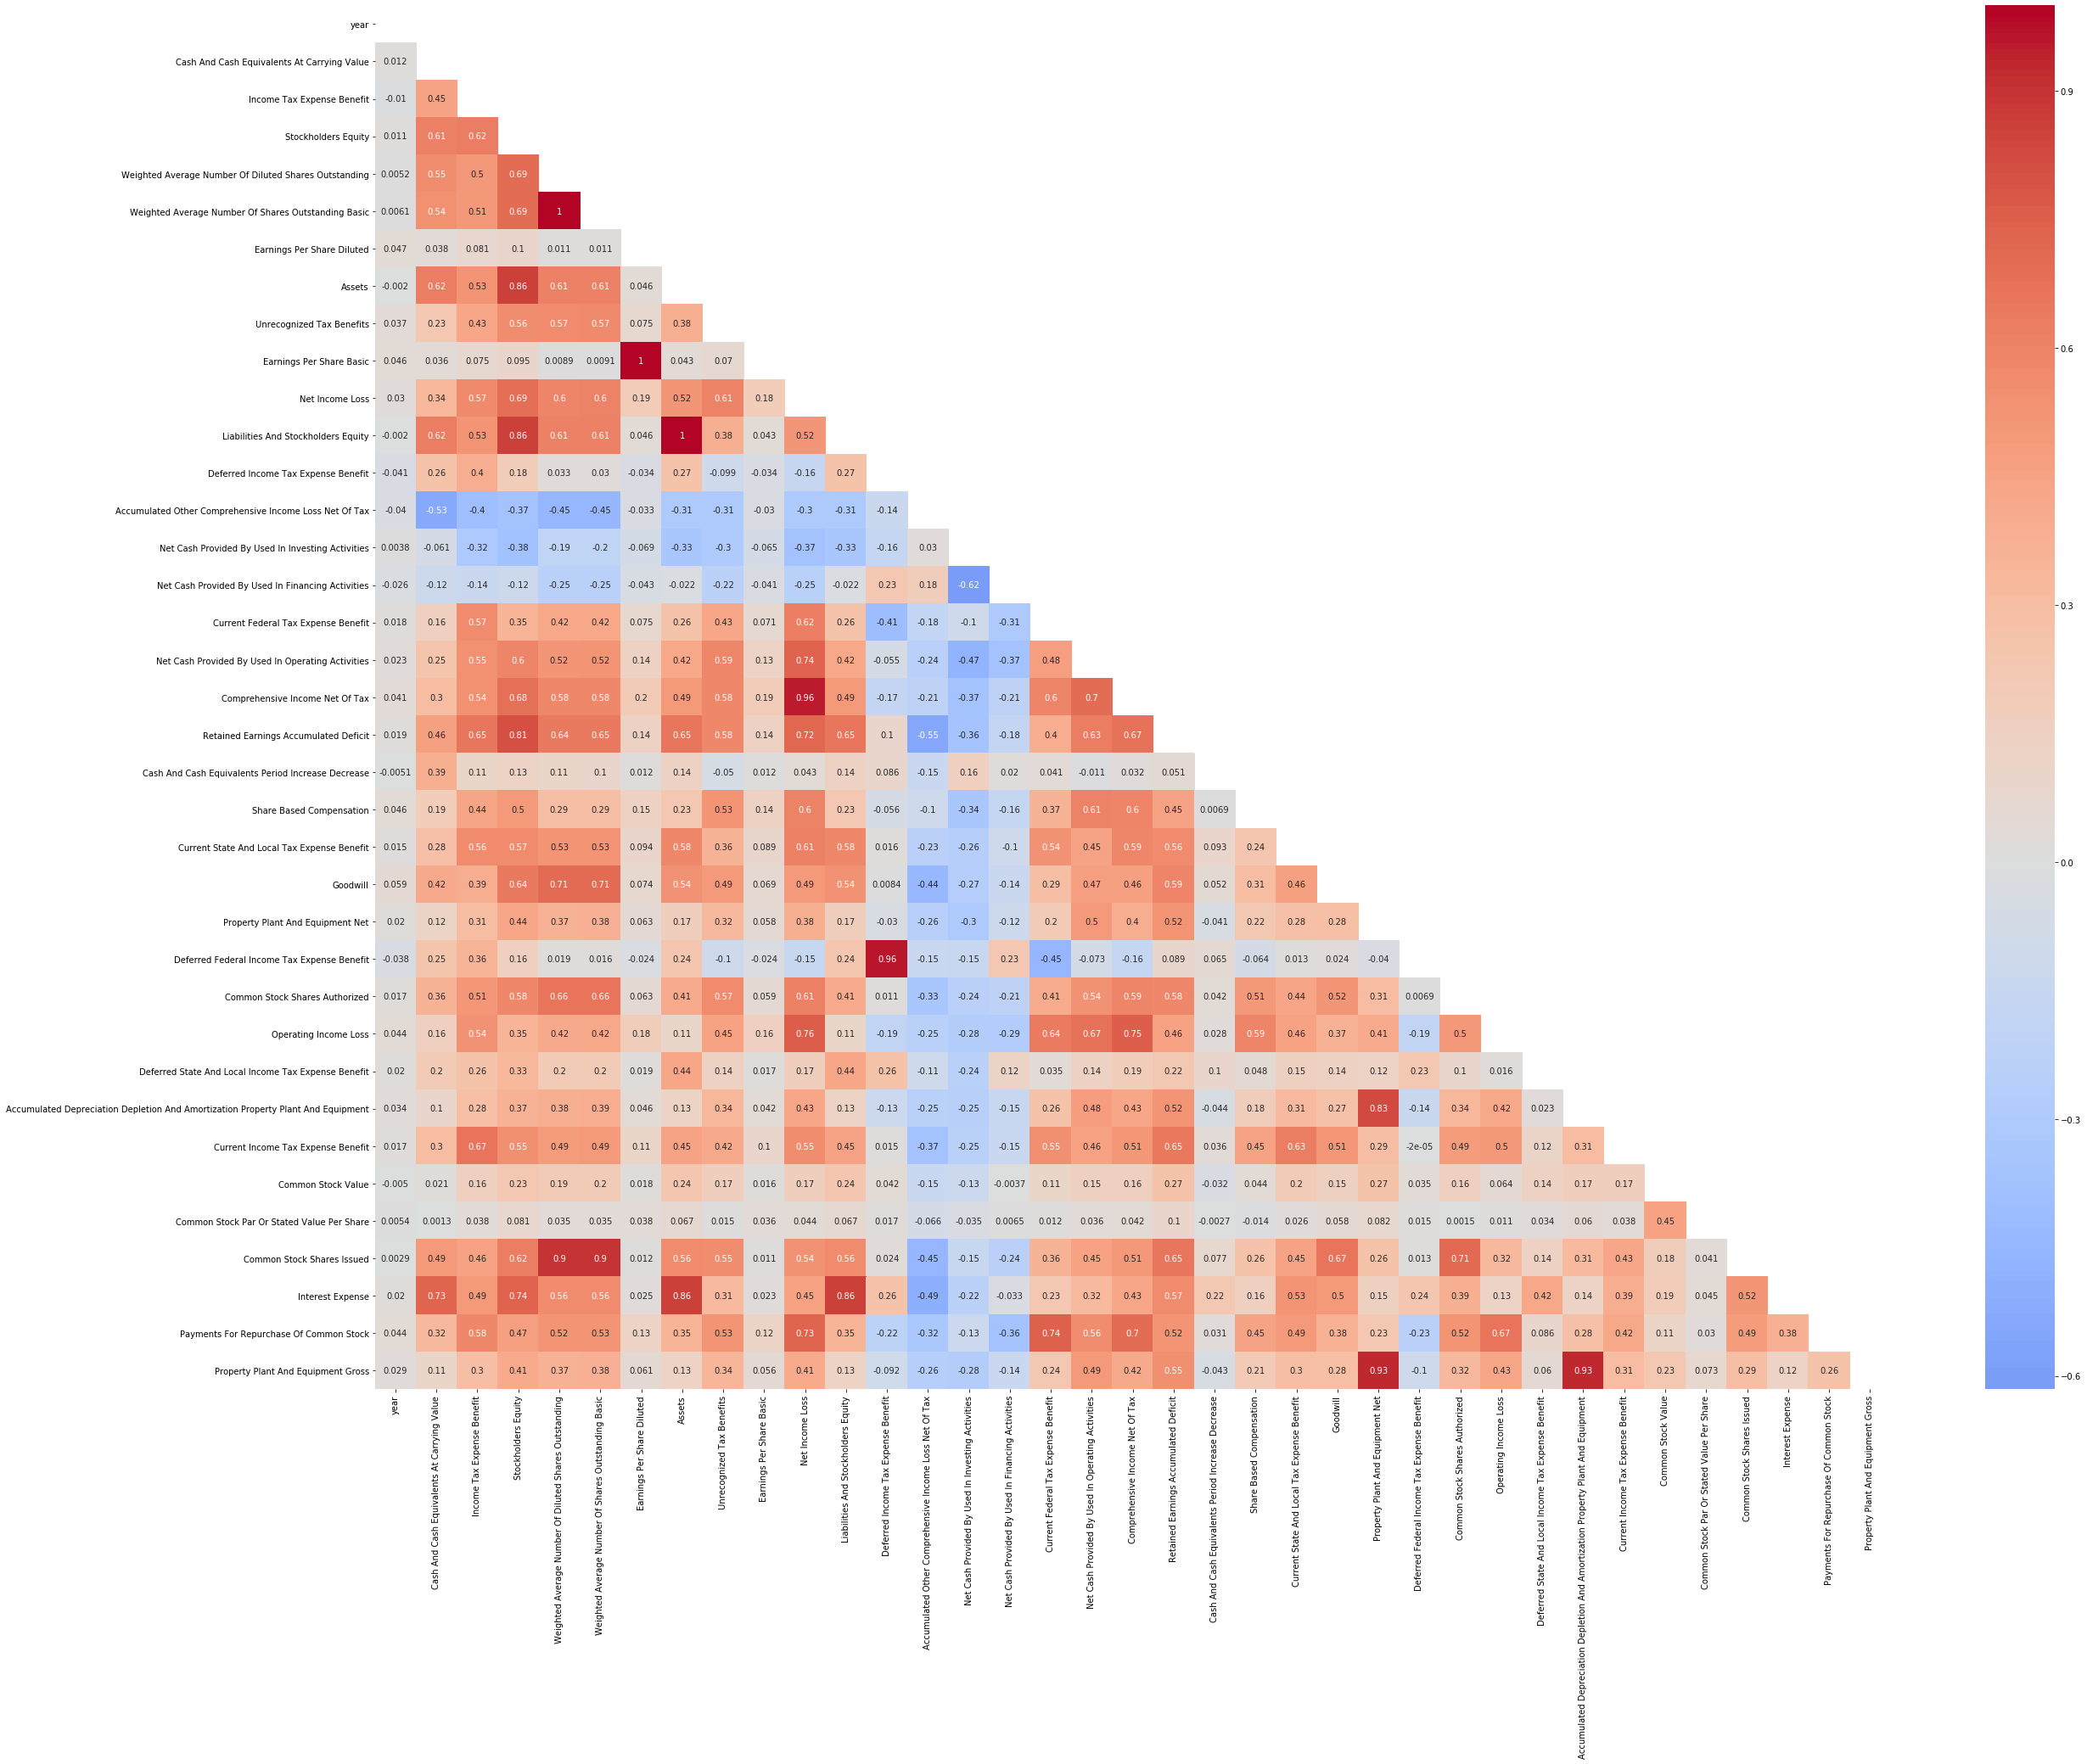

In [18]:
df_corr = df.corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(40, 30))
sns.heatmap(df_corr,
            cmap='coolwarm',
            center=0,
            annot=True,
            mask=mask);

In [19]:
# To drop one of the two features with correlation of 1
df.drop(
    columns=[
        'Earnings Per Share Diluted',
        'Liabilities And Stockholders Equity',
        'Weighted Average Number Of Diluted Shares Outstanding'
    ],
    inplace=True
)

---

## Export To `csv`

In [20]:
df.to_csv('../data/clean.csv', index=False)